In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from tqdm import tqdm
import math
import requests, lxml, re, json
import pickle
from umap import UMAP
import plotly.express as px
from grb.light_curves import *
from grb.furie import *
from grb.time import *
from grb.config import DATA_PATH, IMAGE_PATH, logging
from grb.utils import Chi2_polyval
from grb.blind_search import process_time_window, filter_missing_data_and_flares,recursive_event_search

Initialize search conditions for 3 time scales

In [4]:
search_conditions = {1000:{
    'n_bins':9,
    'sigma_threshold':3,
    'chi_2_limit':4.5
    },
    300:{
    'n_bins':29,
    'sigma_threshold':5,
    'chi_2_limit':4.5
    },
    120:{
    'n_bins':29,
    'sigma_threshold':7,
    'chi_2_limit':3
    }}

Start blind search: iterate over search_conditions, select time window appropriat for this scale, construct backgtound model for this window and check central bin for statistical significance

In [ ]:
events = []
for scale in search_conditions:
    ACS_data = np.loadtxt(f'{DATA_PATH}acs_0040-2435__mean__T{scale}.dat')

    # filter data
    ACS_data = filter_missing_data_and_flares(ACS_data)

    times = ACS_data[:,0]
    signal = ACS_data[:,2]
    gap = np.median(times[1:] - times[:-1])

    # no need in using LightCurve class, data is already rebined and filtered
    for i in tqdm(range(times.shape[0]-search_conditions[scale]['n_bins']-1)):
        if (times[i + search_conditions[scale]['n_bins']] - times[i]) < gap * (search_conditions[scale]['n_bins']+3):
            sub_time = times[i:i + search_conditions[scale]['n_bins']]
            sub_counts = signal[i:i + search_conditions[scale]['n_bins']]
            center_bin = int(search_conditions[scale]['n_bins']//2)
            utc_time,significance,chi_2 = process_time_window(sub_time, sub_counts, center_bin, search_conditions[scale]['sigma_threshold'])
            if utc_time is not None:
                events.append({'time':utc_time, 'significance':significance, 'chi_2':chi_2, 'scale':scale})


KeyboardInterrupt: 

Every candidate shoud be processed on smaler time scale, to determine flux, duration and light_curve bins

In [ ]:
def process_file(filename,left=None,right=None):
    try:
        x,x_err,y,y_err = np.hsplit(np.loadtxt(f"data/{filename}"),4)
        x = x.reshape(-1,)
        x = x - 8421.84
        x_err = x_err.reshape(-1,)
        y = y.reshape(-1,)
        y_err = y_err.reshape(-1,)

        x_ev,y_ev,mod_3=p=find_event(x,y)
        if left is None:
            left = np.min(x_ev)
            right = np.max(x_ev)
        else:
            x_ev = x[(x>left)&(x<right)]
            y_ev = y[(x>left)&(x<right)]
        chi=Chi2_polyval(x[(x<=left)|(x>=right)],y[(x<=left)|(x>=right)],mod_3)
        
        return y_ev,x_ev,mod_3,chi,left,right
    except TypeError:
        return [],[],[],0,left,right
    except ValueError:
        return [],[],[],0,left,right

In [3]:
df_candidates = pd.read_excel(f'{DATA_PATH}candidates_crossmatched_final (2).xlsx',parse_dates=['datetime'])
df_candidates

,Unnamed: 0,datetime,distance,duration,duration_err,integral_flux,integral_flux_err,significance,bkg_chi2,Bkg,Hurley,RHESSI,Konus,GOES,Candidate
0,0,2003-02-14 09:49:43.816,1.17,380,60,102959,4944,20.8,4.8,1,0,0,0,0,0
1,1,2003-02-15 11:13:44.816,0.23,260,60,618852,3481,177.8,34.0,1,1,0,0,0,0
2,2,2003-02-15 15:41:43.816,0.04,560,60,1413011,6509,217.1,2.9,0,0,0,0,0,1
3,3,2003-02-16 10:33:43.816,0.74,440,60,56108,5475,10.2,2.0,0,0,0,0,0,1
4,4,2003-02-17 02:42:43.816,1.42,260,60,375627,3453,108.8,17.0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,5475,2020-11-09 23:12:08.992,0.48,1400,200,63982,13505,4.7,1.3,0,0,0,0,0,1
5476,5476,2020-11-23 13:25:29.996,0.13,200,200,16241,6002,2.7,1.1,0,0,0,0,0,1
5477,5477,2020-11-23 13:58:49.998,0.12,200,200,13160,6002,2.2,1.0,0,0,0,0,0,1
5478,5478,2020-11-25 12:42:08.996,1.20,200,200,12309,6015,2.0,1.1,0,0,0,0,0,1


In [5]:
with open(f'{DATA_PATH}fixed_durations.pkl','rb') as f:
    final_catalog = pickle.load(f)
df_fixed_durs = pd.DataFrame(final_catalog)

In [6]:
df_fixed_durs

,datetime,event_time,duration,resolution,acs_flux,chi_2,bins
0,2003-02-14 09:49:43.816,164.804459,194.807866,15.000,1.010940e+05,1.8,"[0.11574814627205356, 0.17832570964751787, 0.1..."
1,2003-02-15 11:13:44.816,131.066354,82.402611,7.500,6.216833e+05,10.7,"[0.0, 0.006219142464290014, 0.0065218629200692..."
2,2003-02-15 15:41:43.816,134.493933,418.676969,30.000,1.410639e+06,4.3,"[0.0, 0.0047844677300591595, 0.008117081742619..."
3,2003-02-16 10:33:43.816,-59.884115,717.356425,60.000,7.009510e+04,0.6,"[0.034826925406951856, 0.002401487333419119, 0..."
4,2003-02-17 02:42:43.816,-149.374733,1372.921857,60.000,7.235530e+05,51.4,"[0.0, 0.0162534253236457, 0.5576596927825326, ..."
...,...,...,...,...,...,...,...
5488,2020-11-09 23:12:08.992,-1123.449910,21.875090,3.125,4.990970e+03,6.9,"[0.1385174841271378, 0.11427047277615013, 0.04..."
5489,2020-11-23 13:25:29.996,1342.204961,9.375096,3.125,2.402102e+03,9.0,"[0.17610188257414286, 0.09107453054391174, 0.1..."
5490,2020-11-23 13:58:49.998,89.060793,34.375479,3.125,8.414299e+03,9.7,"[0.011835550463630044, 0.14444421370010052, 0...."
5491,2020-11-25 12:42:08.996,-17.192246,28.125413,3.125,6.866969e+03,13.8,"[0.12375063632692031, 0.05614617787745118, 0.0..."


In [7]:
for i,event in tqdm(df_candidates.iloc[4955:].iterrows()):
    try:
        logging.info(f'Processing {i}/{df_candidates.shape[0]} {event["datetime"]}')
        lc_acs=SPI_ACS_LightCurve(event["datetime"].strftime("%Y-%m-%d %H:%M:%S"),1000+event["duration"]*3.5)
        lc_acs.rebin(event["duration_err"]).filter_peaks(-10)

        times_left, times_right, resolution = recursive_event_search(lc_acs, event["duration_err"], filter_values=-10)
        event_times, event_signal = limit_to_time_interval(lc_acs.times,lc_acs.signal,(times_left, times_right))

        lc_acs.rebin(resolution).filter_peaks(-10)
        params = np.polyfit(*exclude_time_interval(lc_acs.times,lc_acs.signal,(times_left, times_right)),3)
        duration = times_right - times_left
        chi_2 = Chi2_polyval(*exclude_time_interval(lc_acs.times,lc_acs.signal,(times_left, times_right)),params)

        fig = plt.figure(figsize=(8,8),dpi=300)
        lc_acs.plot(kind='errorbar')

        plt.ylabel(f'ACS Counts \ {resolution} sec')
        plt.xlabel('Time (s)')
        plt.xlim(times_left-duration*3,times_right+duration*3)
        plt.ylim(np.min(event_signal) - 0.2*(np.max(event_signal) - np.min(np.polyval(params,event_times))),np.max(event_signal) + 0.2*(np.max(event_signal) - np.min(np.polyval(params,event_times))))
        plt.plot(lc_acs.times,np.polyval(params,lc_acs.times))
        plt.fill_between(event_times,event_signal, np.polyval(params,event_times), step="mid", color="red", alpha=0.3)
        plt.title(f"{lc_acs.event_time}")
        plt.plot([], [], ' ', label=f"Duration = {round(duration,2)} +- {resolution} sec")
        plt.plot([], [], ' ', label=f"Area = {int(np.sum(event_signal-np.polyval(params,event_times)))} +- {int(np.sqrt(np.sum(np.polyval(params,event_times))*1.35))}")
        plt.plot([], [], ' ', label=f"Sigma = {round(np.sum(event_signal-np.polyval(params,event_times))/np.sqrt(np.sum(np.polyval(params,event_times))*1.35),1)}")
        plt.plot([], [], ' ', label=f"Chi2_bkg_qubic = {round(chi_2,1)}")
        plt.legend(loc='upper right')
        plt.savefig(f"{IMAGE_PATH}{lc_acs.event_time.replace(' ','T').replace(':','_')}.png")
        plt.close(fig)
        logging.info(f'Plotted {event["datetime"]}')
        lc_acs.rebin().set_intervals((times_left, times_right)).rebin(duration/11,False)
        rebined_param = params * ((duration/11)/resolution)

        signal = (lc_acs.signal - np.polyval(rebined_param,lc_acs.times))[:10]
        bins = (signal - signal.min())/np.sum(signal - signal.min())

        final_catalog.append({'datetime':event["datetime"],
                            'event_time':times_left,
                            'duration':duration,
                            'resolution':resolution,
                            'acs_flux':np.sum(event_signal-np.polyval(params,event_times)),
                            'chi_2':round(chi_2,1),
                            'bins':bins})
    except Exception as e:
        logging.exception(f'{e}')
        final_catalog.append({'datetime':event["datetime"],
                            'event_time':0,
                            'duration':0,
                            'resolution':1e3,
                            'acs_flux':0,
                            'chi_2':0,
                            'bins':np.array([0 for _ in range(10)])})
    finally:
        with open(f'{DATA_PATH}fixed_durations.pkl','wb') as f:
            pickle.dump(final_catalog,f)

0it [00:00, ?it/s]c:\Users\georg\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\georg\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\georg\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Python projects\pygrb\grb\light_curves.py:171: RuntimeWarning: divide by zero encountered in true_divide
  indexes_to_remove = (self.signal - median_flux)/np.nan_to_num(self.signal_err,nan=1) < peak_threshold
1it [00:11, 11.56s/it]c:\Users\georg\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\georg\ana

In [5]:
r = df_candidates.merge(df_fixed_durs,left_on='datetime',right_on='datetime').sort_values('datetime')
r['duration'] = np.where(2*r['duration_x']<r['duration_y'],r['duration_x'],r['duration_y'])
r['GRB'] = r['Hurley']|r['Konus']
r['SOLAR'] = r['RHESSI']|r['GOES']

In [2]:
r = pd.read_csv(f'{DATA_PATH}candidates_after_konus_flares.csv')
r['GRB'] = r['Hurley']|r['Konus']
r['SOLAR'] = r['RHESSI']|r['GOES']

In [12]:
r['type'] = np.where(r['crossmatched'],'crossmatched',np.where(r['Bkg'],'Bkg',np.where(r['GRB'],'GRB','SOLAR')))
px.scatter(data_frame=r[r['acs_flux']>0], x='duration', y='acs_flux', color='type', log_x=True, log_y=True, marginal_x="box", marginal_y="box")

In [14]:
r[r['SOLAR']==1]['crossmatched'].sum()

92

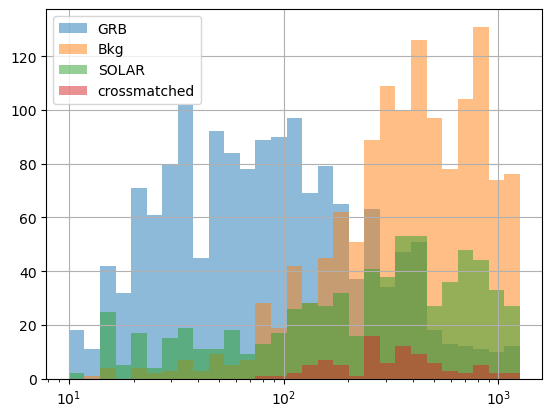

In [5]:
r[r['GRB']==1]['duration'].hist(bins=np.logspace(1,3.1,30),label='GRB',alpha=0.5)
r[r['Bkg']==1]['duration'].hist(bins=np.logspace(1,3.1,30),label='Bkg',alpha=0.5)
r[r['SOLAR']==1]['duration'].hist(bins=np.logspace(1,3.1,30),label='SOLAR',alpha=0.5)
r[r['crossmatched']==1]['duration'].hist(bins=np.logspace(1,3.1,30),label='crossmatched',alpha=0.5)
# r[r['Candidate']==1]['duration'].hist(bins=np.logspace(1,3.1,30),label='Candidate',alpha=0.3)
plt.xscale('log')
plt.legend()

In [13]:
df_candidates = pd.read_excel('data/df_candidates.xlsx',parse_dates=['datetime'])
df_candidates

,datetime,acs_flux,duration,distance_x,iremtc3.da_flux,ibis_veto__flux,isgri_E20-_flux,jmx1_E3-20_flux,jmx2_E3-20_flux,picsit_evt_flux,...,3_bin,4_bin,5_bin,6_bin,7_bin,8_bin,9_bin,umaped_1,umaped_2,proba_grb
0,2003-02-12 03:38:53.978,1.420889e+04,2200,141336.022306,0.000000,-1.893907,0.482576,0.282749,-0.635029,0.0,...,0.088149,0.071073,0.053946,0.037140,0.229800,0.215253,0.0,14.801283,2.642046,0.074885
1,2003-02-14 09:52:14.990,9.834545e+04,1199,158454.564151,147642.781250,4.596952,84.902000,15.815167,21.097311,0.0,...,0.142200,0.138002,0.121868,0.096249,0.067715,0.038492,0.0,7.952449,6.388126,0.691192
2,2003-02-15 15:43:23.816,1.624622e+06,440,88156.850574,-46072.156250,-6.703867,26350.390754,2978.366872,3711.169464,0.0,...,0.123165,0.154903,0.161069,0.151984,0.143316,0.094671,0.0,0.578760,11.967870,0.118935
3,2003-02-15 15:41:43.816,2.248191e+06,560,87625.935867,-206891.156250,-22.227615,11269.077273,1361.633627,1711.866101,0.0,...,0.125477,0.140467,0.162197,0.171827,0.143283,0.089686,0.0,-0.034294,12.725553,0.072811
4,2003-02-15 15:43:43.816,1.624622e+06,420,88156.850574,-46072.156250,-6.703867,26350.390754,2978.366872,3711.169464,0.0,...,0.124720,0.155991,0.170502,0.149939,0.141818,0.093347,0.0,0.554029,11.980402,0.032292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1343,2021-10-22 00:44:38.816,7.865350e+05,500,119037.231057,13088.992188,28615.829285,-0.398237,214.645284,416.682898,0.0,...,0.125259,0.152736,0.150233,0.166065,0.147864,0.088131,0.0,4.149312,11.386262,0.218713
1344,2021-10-23 13:02:39.816,3.555135e+05,380,144457.241113,71657.815430,5428.494629,0.000000,0.000000,0.000000,0.0,...,0.124724,0.156978,0.175520,0.162030,0.131420,0.088017,0.0,6.148611,10.063102,0.976545
1345,2021-10-23 13:04:14.816,3.417709e+05,340,144448.395876,71657.815430,5410.608887,0.000000,0.000000,0.000000,0.0,...,0.126151,0.154162,0.174778,0.171740,0.132046,0.077277,0.0,6.163755,10.055752,0.967303
1346,2021-11-05 04:33:03.816,4.280180e+05,320,78249.730721,0.000000,9699.613711,0.000000,0.000000,0.000000,0.0,...,0.124462,0.151163,0.169337,0.169724,0.142381,0.073193,0.0,6.331225,11.549729,0.934335


Количество кандидатов в гамма-всплески, пороог вероятности 0.5

In [ ]:
df_candidates[df_candidates['proba_grb']>0.99].shape

(7, 25)

Гистограммы по длительности

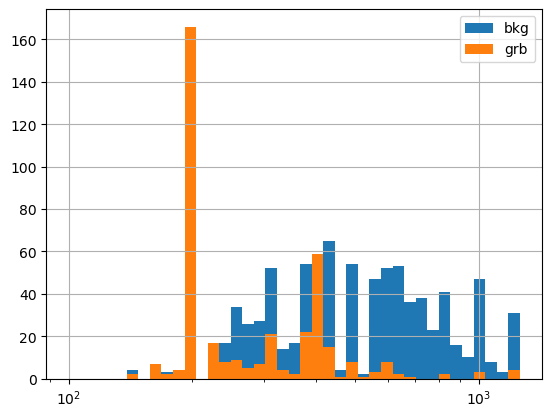

In [ ]:
df_candidates[df_candidates['proba_grb']<0.5]['duration'].hist(bins=np.logspace(2,3.1,40),label='bkg')
df_candidates[df_candidates['proba_grb']>0.5]['duration'].hist(bins=np.logspace(2,3.1,40),label='grb')
plt.xscale('log')
plt.legend()

In [ ]:
final = pd.read_excel('data/candidates_crossmatched_final (2).xlsx')
final['datetime_start'] = (final['datetime']-pd.to_timedelta(2*final['duration'], unit='s')).dt.strftime('%Y-%m-%dT%H:%M:%S')
final['datetime_finish'] = (final['datetime']+pd.to_timedelta(3*final['duration'], unit='s')).dt.strftime('%Y-%m-%dT%H:%M:%S')
final['dT'] = (final['duration_err']/10).astype(int)
df = pd.read_csv('data/candidates_detector_data.csv',parse_dates=['datetime']).set_index('datetime').merge(final.set_index('datetime'),left_index=True,right_index=True)[['acs_flux','duration','distance_x','iremtc3.da_flux','ibis_veto__flux','isgri_E20-_flux','jmx1_E3-20_flux','jmx2_E3-20_flux','picsit_evt_flux','picsit_spe_flux','spi_E20-50_flux','Bkg', 'Hurley','RHESSI', 'Konus', 'GOES', 'Candidate']]
df_cand = pd.read_csv('data/candidates_bins_data.csv',parse_dates=['datetime']).set_index('datetime')
df_cand = df_cand.apply(lambda x:(x-np.min(x))/np.sum(x-np.min(x)),axis=1)
df = df.merge(df_cand,left_index=True,right_index=True)
df = df[df!=np.inf].dropna()
df

,acs_flux,duration,distance_x,iremtc3.da_flux,ibis_veto__flux,isgri_E20-_flux,jmx1_E3-20_flux,jmx2_E3-20_flux,picsit_evt_flux,picsit_spe_flux,...,0_bin,1_bin,2_bin,3_bin,4_bin,5_bin,6_bin,7_bin,8_bin,9_bin
datetime,,,,,,,,,,,,,,,,,,,,,
2003-02-14 09:49:43.816,99709.228577,380,158453.991691,147642.781250,4.597248,241.587233,52.299291,70.301765,0.0,441.681107,...,0.016960,0.051848,0.092503,0.124724,0.156978,0.175520,0.162030,0.131420,0.088017,0.0
2003-02-15 11:12:13.993,48849.252930,399,114211.591765,0.000000,-0.506576,-1.891384,-0.394558,-0.355817,0.0,49.849897,...,0.016107,0.050850,0.091839,0.125304,0.157111,0.175038,0.156872,0.134901,0.091978,0.0
2003-02-15 11:13:44.816,87139.530457,260,112863.210584,-29143.187500,-1.163334,909.150373,83.790173,114.181686,0.0,164.760406,...,0.018568,0.053106,0.085824,0.124179,0.149521,0.165060,0.166103,0.145546,0.092094,0.0
2003-02-15 11:14:03.816,80037.297424,180,112873.337338,-14568.156250,-1.051227,2480.009488,232.289831,318.553010,0.0,316.403992,...,0.021596,0.051352,0.088486,0.122291,0.151155,0.173751,0.164228,0.139799,0.087343,0.0
2003-02-17 02:42:43.816,124275.544189,260,150300.495887,185770.187500,-7.991562,132.308917,95.925394,95.577247,0.0,26.920962,...,0.018568,0.053106,0.085824,0.124179,0.149521,0.165060,0.166103,0.145546,0.092094,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22 00:44:38.816,786535.042480,500,119037.231057,13088.992188,28615.829285,-0.398237,214.645284,416.682898,0.0,308.456360,...,0.023482,0.056102,0.090128,0.125259,0.152736,0.150233,0.166065,0.147864,0.088131,0.0
2021-10-23 13:02:39.816,355513.531250,380,144457.241113,71657.815430,5428.494629,0.000000,0.000000,0.000000,0.0,0.000000,...,0.016960,0.051848,0.092503,0.124724,0.156978,0.175520,0.162030,0.131420,0.088017,0.0
2021-10-23 13:04:14.816,341770.945312,340,144448.395876,71657.815430,5410.608887,0.000000,0.000000,0.000000,0.0,0.000000,...,0.018445,0.052969,0.092430,0.126151,0.154162,0.174778,0.171740,0.132046,0.077277,0.0


In [ ]:
df['GRB'] = df['Hurley']|df['Konus']
df['SOLAR'] = df['RHESSI']|df['GOES']

In [ ]:
transformed = UMAP(n_neighbors=30).fit_transform(df)

In [ ]:
df['umaped_1'] = transformed[:,0]
df['umaped_2'] = transformed[:,1]

In [ ]:
fig = px.scatter(x=transformed[[True if ((row['GRB']==1) or (row['Bkg']==1)) else False for i,row in df.iterrows()],0],
                 y=transformed[[True if ((row['GRB']==1) or (row['Bkg']==1)) else False for i,row in df.iterrows()],1],
                 color = [0 if row['GRB']==1 else 2 if row['Bkg']==1 else 1 for i,row in df.iterrows() if ((row['GRB']==1) or (row['Bkg']==1))])
fig.show()

In [ ]:
data = None
for idx,detector in enumerate(['Bkg','GRB','SOLAR']):
    tmp = df[df[detector]==1][['acs_flux', 'duration', 'distance_x', 'iremtc3.da_flux',
       'ibis_veto__flux', 'isgri_E20-_flux', 'jmx1_E3-20_flux',
       'jmx2_E3-20_flux', 'picsit_evt_flux', 'picsit_spe_flux',
       'spi_E20-50_flux','0_bin', '1_bin', '2_bin', '3_bin', '4_bin', '5_bin',
       '6_bin', '7_bin', '8_bin', '9_bin','umaped_1','umaped_2']]
    tmp['label'] = idx
    data = pd.concat((data,tmp))

In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import fbeta_score,balanced_accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV

In [ ]:
X = data.drop(columns=['label'])
Y = data['label']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,Y_train,verbose=1)
print(fbeta_score(Y_test,lgbm.predict(X_test),beta=2,average='weighted'),
      balanced_accuracy_score(Y_test,lgbm.predict(X_test)),
      roc_auc_score(Y_test,lgbm.predict_proba(X_test),multi_class='ovr'))

c:\Users\georg\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



0.618883612377615 0.5538220854667997 0.7730194708536451


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
y_score = lgbm.predict_proba(X_test)
fig, ax = plt.subplots(figsize=(6, 6))

fig = plt.Figure()
for class_id,classs in enumerate(['Bkg','GRB','SOLAR']):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {classs}",
        ax = ax
    )
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for random prediction (AUC = 0.5)")
plt.show()

NameError: name 'Y_train' is not defined

Уберём SOLAR т.к. точность ужасная

In [ ]:
data_pruned = None
for idx,detector in enumerate(['Bkg','GRB']):
    tmp = df[df[detector]==1][['acs_flux', 'duration', 'distance_x', 'iremtc3.da_flux',
       'ibis_veto__flux', 'isgri_E20-_flux', 'jmx1_E3-20_flux',
       'jmx2_E3-20_flux', 'picsit_evt_flux', 'picsit_spe_flux',
       'spi_E20-50_flux','0_bin', '1_bin', '2_bin', '3_bin', '4_bin', '5_bin',
       '6_bin', '7_bin', '8_bin', '9_bin','umaped_1','umaped_2']]
    tmp['label'] = idx
    data_pruned = pd.concat((data_pruned,tmp))

In [ ]:
X_pruned = data_pruned.drop(columns=['label'])
Y_pruned = data_pruned['label']
X_train_2,X_test_2,Y_train_2,Y_test_2 = train_test_split(X_pruned,Y_pruned)

lgbm_2 = LGBMClassifier()
lgbm_2.fit(X_train_2,Y_train_2,verbose=1)

print(fbeta_score(Y_test_2,lgbm_2.predict(X_test_2),beta=2,average='weighted'),
      balanced_accuracy_score(Y_test_2,lgbm_2.predict(X_test_2)),
      roc_auc_score(Y_test_2,lgbm_2.predict(X_test_2)))

0.8648410681178113 0.8649964607139246 0.8649964607139247


c:\Users\georg\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



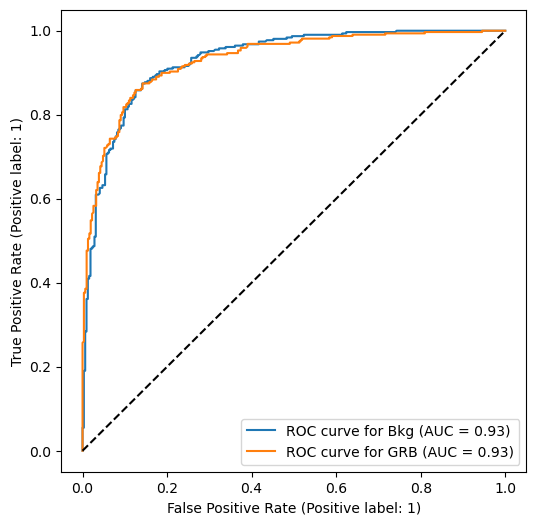

In [ ]:
label_binarizer_2 = LabelBinarizer().fit(Y_train_2)
y_onehot_test_2 = label_binarizer.transform(Y_test_2)
y_score_2 = lgbm_2.predict_proba(X_test_2)
fig, ax = plt.subplots(figsize=(6, 6))

fig = plt.Figure()
for class_id,classs in enumerate(['Bkg','GRB']):
    RocCurveDisplay.from_predictions(
        y_onehot_test_2[:, class_id],
        y_score_2[:, class_id],
        name=f"ROC curve for {classs}",
        ax = ax
    )
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for random prediction (AUC = 0.5)")
plt.show()

Рассмотрим отдельно кандидаты

In [ ]:
df_candidates = df[df['Candidate']==1][lgbm_2.feature_name_]
df_candidates['proba_grb'] = lgbm_2.predict_proba(df_candidates)[:,1]

Text(0.5, 0, 'distance, km')

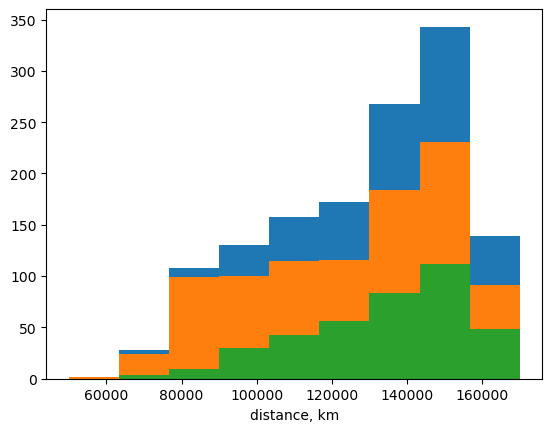

In [ ]:
bins_all,a,b = plt.hist(df_candidates['distance_x'],bins=np.linspace(50000,170000,10))
bins_bkg,_,_ = plt.hist(df_candidates[df_candidates['proba_grb']<0.5]['distance_x'],bins=np.linspace(50000,170000,10))
bins_grb,_,_ = plt.hist(df_candidates[df_candidates['proba_grb']>0.5]['distance_x'],bins=np.linspace(50000,170000,10))
plt.xlabel('distance, km')

Text(0.5, 0, 'distance, km')

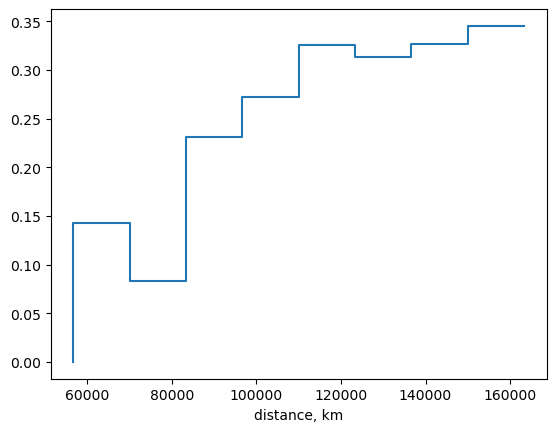

In [ ]:
plt.step((a[1:]+a[:-1])/2,bins_grb/bins_all)
plt.xlabel('distance, km')

In [ ]:
bins_grb/bins_all

array([0.        , 0.14285714, 0.08333333, 0.23076923, 0.2721519 ,
       0.3255814 , 0.31343284, 0.32653061, 0.34532374])

<AxesSubplot:xlabel='name'>

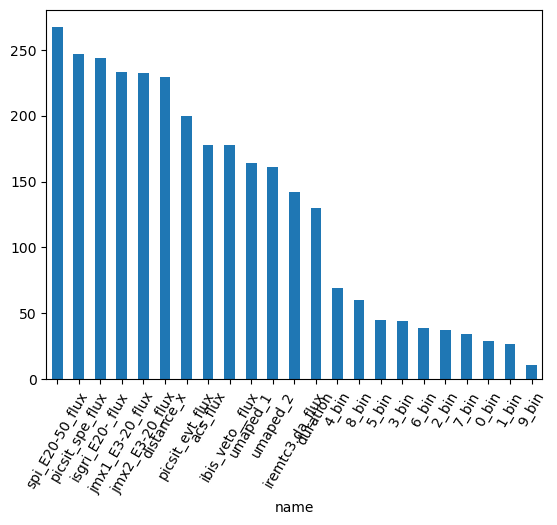

In [ ]:
feature_imps = pd.DataFrame(list(zip(lgbm_2.feature_name_,lgbm_2.feature_importances_)),columns=['name','importance']).set_index('name').sort_values('importance',ascending=False)
feature_imps['importance'].plot(kind='bar',rot=60)

In [ ]:
with open('model_bkg-grb_lgbm.pkl','wb') as f:
    pickle.dump(lgbm_2,f)

In [ ]:
df_candidates.sort_values('proba_grb',ascending=False).head(5)

,acs_flux,duration,distance_x,iremtc3.da_flux,ibis_veto__flux,isgri_E20-_flux,jmx1_E3-20_flux,jmx2_E3-20_flux,picsit_evt_flux,picsit_spe_flux,...,3_bin,4_bin,5_bin,6_bin,7_bin,8_bin,9_bin,umaped_1,umaped_2,proba_grb
datetime,,,,,,,,,,,,,,,,,,,,,
2012-02-09 01:34:42.816,69194.109863,159,159620.452046,0.000000,132.182596,-12.959245,0.974687,-2.032345,2.848637,-174.721008,...,0.120209,0.152005,0.170474,0.172328,0.139074,0.086258,0.0,12.215276,5.581679,0.999257
2014-02-07 10:12:41.816,51359.980469,200,161630.433264,0.000000,13748.181152,763.182281,-32.131243,15.348358,3.631271,602.822510,...,0.122481,0.154458,0.168951,0.164542,0.140393,0.087556,0.0,12.726770,4.556560,0.997667
2011-10-15 07:56:04.816,30505.972412,160,162388.717689,-20387.000000,-1.113487,-51.800309,5.126428,-13.358410,1.517628,-315.118164,...,0.121157,0.151448,0.170465,0.171316,0.138509,0.086653,0.0,13.187797,3.304161,0.997209
2015-06-02 20:10:36.816,45002.792480,160,145251.722444,0.000000,106.707053,119.192870,19.593444,9.242370,0.000000,99.825684,...,0.121157,0.151448,0.170465,0.171316,0.138509,0.086653,0.0,12.997866,4.680995,0.995454
2013-07-14 05:20:40.816,231949.109375,380,102230.776853,261897.507812,9430.816162,226.912200,4.947717,10.865303,8.097824,158.044312,...,0.124724,0.156978,0.175520,0.162030,0.131420,0.088017,0.0,5.556072,7.745983,0.994884


In [ ]:
acs_data.get_ijd_from_utc(str(event_datetime)[:19])

'2012-02-09 01:34:42'

In [ ]:
event_datetime = df_candidates.sort_values('proba_grb').reset_index().iloc[3]['datetime']
event_datetime

Timestamp('2017-01-07 14:41:48.816000')

In [ ]:
get_pic(event_datetime)

c:\Users\georg\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning:

Unverified HTTPS request is being made to host '193.232.11.95'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings



In [ ]:
def get_pic(event_datetime):
    row = final.set_index('datetime').loc[event_datetime]
    r = requests.get(f"https://193.232.11.95/lvc/r/Mozgunov/20220928/Candidates/{acs_data.get_ijd_from_utc(str(row['datetime_start'])[:19])}_{acs_data.get_ijd_from_utc(str(row['datetime_finish'])[:19])}__{row['dT']}s/8det.png",verify=False,stream=True)
    with open(f"pics_bkg/{event_datetime}_pic.png", 'wb') as f:
        f.write(r.raw.read())

In [ ]:
(lgbm.predict(df[df['Candidate']==1][lgbm.feature_name_])==0).sum()

708

In [ ]:
predictions_candidates[predictions_candidates[:,2]>0.9]

array([[0.00364042, 0.08900256, 0.90735702],
       [0.01871828, 0.05195089, 0.92933082],
       [0.04085465, 0.02347452, 0.93567083],
       [0.00833634, 0.06373425, 0.92792941],
       [0.04929869, 0.04314302, 0.90755829],
       [0.03870083, 0.00659941, 0.95469976],
       [0.00618166, 0.04483737, 0.94898097],
       [0.01600175, 0.04967058, 0.93432767],
       [0.02158211, 0.02713736, 0.95128053],
       [0.01417922, 0.049656  , 0.93616478],
       [0.0163482 , 0.01830734, 0.96534447],
       [0.00195011, 0.02858114, 0.96946875],
       [0.01326571, 0.07728263, 0.90945166],
       [0.0428291 , 0.04168958, 0.91548132],
       [0.00646022, 0.05222494, 0.94131484],
       [0.00439527, 0.09426844, 0.9013363 ],
       [0.01467672, 0.03101711, 0.95430617],
       [0.02015284, 0.0114504 , 0.96839676],
       [0.00736121, 0.05023329, 0.9424055 ],
       [0.00940961, 0.06049385, 0.93009653],
       [0.00407899, 0.05496317, 0.94095785],
       [0.03135875, 0.02647403, 0.94216722],
       [0.

In [ ]:
config.ROOT_DIR

'c:\\Python projects\\GRB_data_processing'

In [ ]:
import numpy as np
np.array([1,2,34])

TypeError: array() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
print(*exclude_time_interval(np.array([1,2,5,34]),np.array([1,2,5,34]),(1.5,4)))

[ 1  5 34] [ 1  5 34]


In [ ]:
def recursive_event_search(times: np.array, 
                           signal: np.array, 
                           signal_err: np.array = None, 
                           event_range: tuple = None, 
                           sigma_threshold: float = 3):
    """
    Recieves light curve
    x,y,y_err = same size arrays
    p = np.polyfit parameters vector
    Returns bins with event

    сделать граф и искать связные изолированные подмножества, граф одномерный
    """
    if event_range is None:
        param = np.polyfit(*exclude_time_interval(times,signal,event_range),3)
    else:
        param = np.polyfit(times,signal,event_range,3)
    
    if signal_err is not None:
        signal_sign = (signal - np.polyval(param,times))/signal_err
    else:
        signal_sign = (signal - np.polyval(param,times))/np.sqrt(signal)

    x1=list(x1)
    y1=list(y1)
    sign_array=list(sign_array)
    peak=sign_array.index(max(sign_array))
    peak=x1.index(x_temp[peak])
    left=peak
    right=peak
    sign_array=(np.asarray(y1)-np.polyval(p,np.asarray(x1)))/np.sqrt(np.asarray(y1)*1.35)
    while sign_array[left-1]>1:
        left-=1
        if left==0:
            break
    try:
        while sign_array[right+1]>1:
            right+=1
    except:
        pass

    event=[e for e in range(left,right+1)]

    x1_fixed=[]
    y1_fixed=[]
    for i in range(0,len(x1)):
        if i not in event:
            x1_fixed.append(x1[i])
            y1_fixed.append(y1[i])
    p1=np.polyfit(x1_fixed,y1_fixed,3)
    if (y1_event.shape[0] < 3) or (duration < 10):
        pass
    return x1_event,y1_event,p1

In [ ]:
r = requests.get(f"https://193.232.11.95/lvc/r/AT2023avj/8421.82_8421.86__5s/acs_T5.dat",verify=False,stream=True)
with open(f"data/acs_T5.dat", 'wb') as f:
            f.write(r.raw.read())

c:\Users\georg\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '193.232.11.95'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [ ]:
result = {}
r = requests.get(f"https://193.232.11.95/lvc/r/8421.82_8421.86__5s/",verify=False)
soup = BeautifulSoup(r.text)
left,right= None,None
for detector in sorted([x['href'] for x in soup.find_all('a')[5:] if x['href'] not in ['info.dat','obts.dat','obts.dat.obt2ijd','scws/','8det.png']]):
    r = requests.get(f"https://193.232.11.95/lvc/r/8421.82_8421.86__5s/{detector}",verify=False,stream=True)
    if not os.path.isfile(f"data/{detector}"):
        with open(f"data/{detector}", 'wb') as f:
            f.write(r.raw.read())
    if detector == 'distances.dat':
        y,x,_,_,_,_ = process_file(detector,left=left,right=right)
        if y != []:
            result['distance'] = np.mean(y[(x>left)&(x<right)])
        else:
            result['distance'] = None
    else:
        y,x,par,chi2,left,right = process_file(detector,left=left,right=right)
        if detector[:3] == 'acs':
            name = 'acs'
        else:
            name = detector[:10]

        if y == []:
            result[name+'_flux'] = 0
            result[name+'_chi2'] = None
        else:
            result[name+'_flux'] = np.sum(y-np.polyval(par,x))
            result[name+'_chi2'] = chi2

        if detector[:3] == 'acs':
            duration = ((right - left)/2)*24*60*60
            lc_acs=LightCurve(data=np.hstack((np.asarray(x).reshape(-1,1),np.asarray(y).reshape(-1,1))))
            print(lc_acs.original_resolution)
            print(lc_acs.times,lc_acs.signal)
            lc_acs.rebin(duration/5)
            _,_,p = find_event(lc_acs.times,lc_acs.signal)
            signal = (lc_acs.signal - np.polyval(p,lc_acs.times))[5:15]

            signal = signal + np.min(signal)
            print(signal/np.sum(signal))
            result['bins'] = signal/np.sum(signal)

c:\Users\georg\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '193.232.11.95'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [ ]:
result

{}

In [ ]:
import warnings
import os.path

warnings.filterwarnings("ignore")
# result = {}
try:
    for idx,folder in enumerate(['Candidates_badorbit','Candidates','Crossmatched_badorbit']): #'Crossmatched',
        r = requests.get(f"https://193.232.11.95/lvc/r/Mozgunov/20220928/{folder}/",verify=False)
        soup = BeautifulSoup(r.text)
        for link in tqdm(soup.find_all('a')[5:-2]):
            r = requests.get(f"https://193.232.11.95/lvc/r/Mozgunov/20220928/{folder}/{link['href']}",verify=False)
            soup = BeautifulSoup(r.text)
            start_time = list(acs_data.get_utc_from_ijd(link['href'].split('_')[0])[:19])
            start_time[10]= 'T'
            start_time = ''.join(start_time)
            t0 = final[final['datetime_start']==start_time]['datetime'].values[0]
            if t0 not in result:
                acs_lc = get_acs_lc(pd.to_datetime(str(t0)).strftime("%Y-%m-%d %H:%M:%S"),int(final[final['datetime_start']==start_time]['duration'].values[0]),'ijd')
                left = float(acs_data.get_ijd_from_utc(str(final[final['datetime']==time]['datetime'].values[0])))
                right = float(acs_data.get_ijd_from_utc(str(final[final['datetime']==time]['datetime'].values[0]))) + final[final['datetime_start']==start_time]['duration'].values[0]/(24*60*60)
                result[t0] = {}
                logging.info(f'{t0=},{left=},{right=}')
                try:
                    for detector in sorted([x['href'] for x in soup.find_all('a')[5:] if x['href'] not in ['info.dat','obts.dat','obts.dat.obt2ijd','scws/','8det.png']]):
                        r = requests.get(f"https://193.232.11.95/lvc/r/Mozgunov/20220928/{folder}/{link['href']}/{detector}",verify=False,stream=True)
                        with open(f"pics_bkg/{detector}", 'wb') as f:
                            f.write(r.raw.read())
                        if detector == 'distances.dat':
                            y,x,_,_,_,_ = process_file(detector,left=left,right=right)
                            if y != []:
                                result[t0]['distance'] = np.mean(y[(x>left)&(x<right)])
                            else:
                                result[t0]['distance'] = None
                        else:
                            y,x,par,chi2,left,right = process_file(detector,left=left,right=right)
                            if detector[:3] == 'acs':
                                name = 'acs'
                            else:
                                name = detector[:10]

                            if y == []:
                                result[t0][name+'_flux'] = 0
                                result[t0][name+'_chi2'] = None
                            else:
                                result[t0][name+'_flux'] = np.sum(y-np.polyval(par,x))
                                result[t0][name+'_chi2'] = chi2

                            if detector[:3] == 'acs':
                                duration = ((right - left)/2)*24*60*60
                                lc_acs=ACS_Light_Curve(acs_data.get_utc_from_ijd((left+right)/2)[:19],duration*2)
                                lc_acs.rebin(duration/5)
                                _,_,p = find_event(lc_acs.times,lc_acs.signal)
                                signal = (lc_acs.signal - np.polyval(p,lc_acs.times))[5:15]

                                logging.info(f'{t0},{len(signal)},{signal}')
                                signal = signal + np.min(signal)
                                result[t0]['bins'] = signal/np.sum(signal)          
                except Exception:
                    logging.info(t0,'failed')
except ChunkedEncodingError:
    pass

100%|██████████| 3298/3298 [2:07:22<00:00,  2.32s/it]  


In [ ]:
result

{numpy.datetime64('2003-02-14T04:04:43.816000000'): {'acs_flux': 0.0,
  'acs_chi2': 2.60986548678861,
  'bins': array([0.02428992, 0.05600265, 0.09177723, 0.12417497, 0.15305282,
         0.15496005, 0.15583803, 0.14697852, 0.09113936, 0.00178645]),
  'distance': None,
  'ibis_veto__flux': 0.0,
  'ibis_veto__chi2': 0.0003217389216183344,
  'iremtc3.da_flux': 0.0,
  'iremtc3.da_chi2': 178916319500.29578,
  'isgri_E20-_flux': 0.0,
  'isgri_E20-_chi2': 1.904064997451835,
  'jmx1_E3-20_flux': 0.0,
  'jmx1_E3-20_chi2': inf,
  'jmx2_E3-20_flux': 0.0,
  'jmx2_E3-20_chi2': inf,
  'picsit_evt_flux': 0,
  'picsit_evt_chi2': None,
  'picsit_spe_flux': 0.0,
  'picsit_spe_chi2': 13.705251077885753,
  'spi_E20-50_flux': 0,
  'spi_E20-50_chi2': None},
 numpy.datetime64('2003-02-14T09:49:43.816000000'): {'acs_flux': 0.0,
  'acs_chi2': 2.960017567809595,
  'bins': array([0.03231056, 0.06074965, 0.09388881, 0.12015382, 0.14644479,
         0.16155908, 0.15056338, 0.12561203, 0.0902319 , 0.01848598]),
  

In [ ]:
df_bins = pd.DataFrame([[key]+list(dict_.get('bins')) for key,dict_ in result.items()],
                columns = ['datetime']+[f"{i}_bin" for i in range(10)]).set_index('datetime')

In [ ]:
!pip install numpy==1.23.5

In [ ]:
df_bins.to_csv('candidates_bins_data.csv')

In [ ]:
pd.to_datetime(str(t0)).strftime("%Y-%m-%d %H:%M:%S"),int(final[final['datetime_start']==start_time]['duration'].values[0])

('2006-09-03 07:28:54', 1400)

In [ ]:
from requests.exceptions import ChunkedEncodingError

In [ ]:
for i,row in final.iterrows():
    # try:
    start = row['datetime']
    finish = row['datetime'] + datetime.timedelta(seconds=row['duration']+row['duration_err'])

    central_time = str(row['datetime'] + datetime.timedelta(seconds=row['duration']/2))[:19]
    duration = ((row['duration']+row['duration_err'])/2)*60*60*24

    lc_acs=ACS_Light_Curve(central_time,duration*3)
    lc_acs.rebin(duration/5)
    _,_,p = find_event(lc_acs.times,lc_acs.signal)
    signal = (lc_acs.signal - np.polyval(p,lc_acs.times))[5:15]

    logging.info(f'{time},{len(signal)},{signal}')
    result[time]['bins'] = signal/np.sum(signal)
    # except KeyboardInterrupt:
    #     KeyboardInterrupt()
    # except BaseException as e:
    #     logging.info(time,'failed',e)

KeyboardInterrupt: 

In [ ]:
def create_integral_curve(y):
    y_int = []
    y_temp = np.array(y)
    for i in range(len(y)):
        y_int.append(np.sum(y_temp[0:i]))
    return y_int / np.max(y_int)

def get_intersect(x,y,value):
    intersect_list = list(abs(np.asarray(y) - 0.5))
    center_pos = intersect_list.index(np.min(intersect_list))
    if value > 0.5:
        for i in range(center_pos,len(x)):
            if (y[i] - value) > 0:
                return x[i]
    else:
        for i in range(center_pos,0,-1):
            if (y[i] - value) < 0:
                return x[i]

def is_between(a,x,b):
    return a <= x <= b

def align_lc(x1,y1,x2,x2_err):
    counts = []
    x1 = np.asarray(x1)
    y1 = np.asarray(y1)
    for i in range(len(x2)):
        indx = tuple([np.logical_and(x1 >= x2[i] - x2_err[i],
                                    x1 <= x2[i] + x2_err[i]
                                    )])
        counts.append(np.sum(y1[indx]))
    return np.asarray(counts)

def reverse_align(x1,x1_err,x2,x2_err,y2):
    counts = []
    mult = 60/0.05
    for i in range(len(x1)):
        temp = np.argmin(abs(x2 - x1[i]))
        counts.append(y2[temp]/mult)
    return np.asarray(counts)

def Chi2(x,y,y_err,p):
    """
    Returns Chi square functional
    x,y,y_err = same size arrays
    p = np.polyfit parameters vector
    """
    chi=0
    for i in range(0,len(x)):
        chi=chi+((y[i]-np.polyval(p,x[i]))/y_err[i])**2
    return chi/(len(x)-len(p))

def find_event(x,y):
    """
    Recieves light curve
    x,y,y_err = same size arrays
    p = np.polyfit parameters vector
    Returns bins with event
    """

    x1=np.array(x)
    y1=np.array(y)
    p=np.polyfit(x,y,3)
    y_temp=[]
    x_temp=[]
    for i in range(len(x1)):
        if is_between(-2000,x1[i],2000):
            x_temp.append(x1[i])
            y_temp.append(y1[i])

    sign_array=(np.asarray(y_temp)-np.polyval(p,np.asarray(x_temp)))/np.sqrt(np.asarray(y_temp)*1.35)
    x1=list(x1)
    y1=list(y1)
    sign_array=list(sign_array)
    peak=sign_array.index(max(sign_array))
    peak=x1.index(x_temp[peak])
    left=peak
    right=peak
    sign_array=(np.asarray(y1)-np.polyval(p,np.asarray(x1)))/np.sqrt(np.asarray(y1)*1.35)
    while sign_array[left-1]>1:
        left-=1
        if left==0:
            break
    try:
        while sign_array[right+1]>1:
            right+=1
    except:
        pass

    event=[e for e in range(left,right+1)]

    x1_fixed=[]
    y1_fixed=[]
    for i in range(0,len(x1)):
        if i not in event:
            x1_fixed.append(x1[i])
            y1_fixed.append(y1[i])
    p1=np.polyfit(x1_fixed,y1_fixed,3)

    x1=np.array(x)
    y1=np.array(y)
    y_temp=[]
    x_temp=[]
    for i in range(len(x1)):
        if is_between(-2000,x1[i],2000):
            x_temp.append(x1[i])
            y_temp.append(y1[i])

    sign_array=(np.asarray(y_temp)-np.polyval(p1,np.asarray(x_temp)))/np.sqrt(np.asarray(y_temp)*1.35)
    x1=list(x1)
    y1=list(y1)
    sign_array=list(sign_array)
    peak=sign_array.index(max(sign_array))
    peak=x1.index(x_temp[peak])
    left=peak
    right=peak
    sign_array=(np.asarray(y1)-np.polyval(p1,np.asarray(x1)))/np.sqrt(np.asarray(y1)*1.35)
    while sign_array[left-1]>1:
        left-=1
        if left==0:
            break
    try:
        while sign_array[right+1]>1:
            right+=1
    except:
        pass

    event=[e for e in range(left,right+1)]

    x1_event=[]
    y1_event=[]
    for i in range(0,len(x1)):
        if i in event:
            x1_event.append(x1[i])
            y1_event.append(y1[i])
    return x1_event,y1_event,p1



In [ ]:
len(lc_acs.original_times)

160

In [ ]:
lc_acs=ACS_Light_Curve(central_time,duration)
lc_acs.rebin(duration/5)

16
16
16
16
16
16
16
16
16
16


In [ ]:
lc_acs.signal

[60741.0,
 60869.0,
 60283.0,
 60967.0,
 60466.0,
 60520.0,
 61139.0,
 60980.0,
 60849.0,
 60963.0]

In [ ]:
curve = acs_data()

In [ ]:
result[np.datetime64('2003-02-14T04:04:43.816000000')]['light_curve']['time']

[1140.1576123805,
 1140.1576355287,
 1140.1576586768,
 1140.157681825,
 1140.1577049731]

In [ ]:
candidate_catalog = []
with open('E:\ACS\preliminary_candidates_1000sec.txt','r') as f:
    for line in f:
        line = line.split(',')
        t=Time(line[0],scale='utc')
        t.format = 'jd'
        t = t.value-2451544.5
        line[0] = t
        candidate_catalog.append([line[0],float(line[1])])

In [ ]:
catalog=pd.read_csv('E:/ACS/Konus-WIND catalog_fixed(1).csv')
temp_list=list(catalog['UT'])
ll2=[]
for line in temp_list:
    ll2.append(datetime.datetime.strptime(line, '%Y-%m-%d %H:%M:%S'))
catalog['UT']=ll2

In [ ]:
with open('final_catalog.pkl','wb') as f:
    pickle.dump(final_catalog,f)

In [ ]:
with open('final_catalog.pkl','rb') as f:
    final_catalog = pickle.load(f)

In [ ]:
true_1000sec = pd.DataFrame(final_catalog,columns = ['datetime','distance','duration','duration_err','integral_flux','integral_flux_err','significance','bkg_chi2','type'])

In [ ]:
false = pd.read_excel('crossmatched_final(4)(1).xlsx').drop(columns='Unnamed: 0')
false = false[false['duration_err']!=200]

In [ ]:
true_time = []

'2003-02-14 09:50:48'

In [ ]:
for time in tqdm(false['datetime'][1384:]):
    t=Time(time,scale='utc')
    t.format = 'jd'
    t = t.value-2451544.5
    true_time.append(get_utc_from_ijd(str(t)))

100%|██████████| 2495/2495 [1:07:56<00:00,  1.63s/it]


In [ ]:
false.shape

(3879, 9)

In [ ]:
[x for x in true_time if x in list(set(true_time))]

3879

In [ ]:
list(dict.fromkeys(true_time))

['2003-02-14 09:49:43.816',
 '2003-02-15 11:13:44.816',
 '2003-02-15 15:41:44.816',
 '2003-02-15 15:41:43.816',
 '2003-02-16 10:33:43.816',
 '2003-02-17 02:42:43.816',
 '2003-02-17 04:21:44.816',
 '2003-02-17 14:23:43.816',
 '2003-02-18 11:37:43.816',
 '2003-02-19 12:10:44.816',
 '2003-02-19 16:29:43.816',
 '2003-02-20 16:08:43.816',
 '2003-02-20 20:36:43.816',
 '2003-02-21 00:46:43.816',
 '2003-02-23 04:07:43.816',
 '2003-02-23 09:41:44.816',
 '2003-02-23 16:47:44.816',
 '2003-02-23 22:47:44.816',
 '2003-02-25 14:59:44.816',
 '2003-02-26 03:43:44.816',
 '2003-02-26 08:59:43.816',
 '2003-02-27 14:45:44.816',
 '2003-02-28 21:31:44.816',
 '2003-03-02 10:26:44.816',
 '2003-03-04 13:24:44.816',
 '2003-03-04 17:27:44.816',
 '2003-03-05 00:37:44.816',
 '2003-03-05 02:44:44.816',
 '2003-03-05 10:45:44.816',
 '2003-03-07 00:12:44.816',
 '2003-03-07 05:04:44.816',
 '2003-03-07 14:26:44.816',
 '2003-03-08 04:20:44.816',
 '2003-03-08 07:17:44.816',
 '2003-03-08 09:21:43.816',
 '2003-03-10 07:48:4

In [ ]:
false['datetime_corrected'] = list(dict.fromkeys(true_time))

In [ ]:

false.to_excel('corrected_without_1000.xlsx')

In [ ]:
true_1000sec.to_excel('true_1000sec.xlsx')



In [ ]:
get_utc_from_ijd(1140.16003685185),get_utc_from_ijd(1140.18665722222)


('2003-02-14 03:49:23.000', '2003-02-14 04:27:43.000')

In [ ]:
get_ijd_from_utc('2003-02-14 03:49:23'),get_ijd_from_utc('2003-02-14 04:27:43')

(1140.16003685185, 1140.18665722222)